# Analyse SEI Parameter Sensitivity Errors wrt Baseline Sim

In [1]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import dfols
import signal
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy import interpolate
from stopit import threading_timeoutable as timeoutable
import os


eSOH_DIR = "./data/esoh_V/"
oCV_DIR = "./data/ocv/"
fig_DIR = "./figures/figures_sens/"
res_DIR = "./data/results_sens/"

In [2]:
plt.rcParams["lines.markersize"] = 5
plt.rcParams["lines.linewidth"] = 2
plt.rcParams["xtick.minor.visible"] = True
plt.rcParams["ytick.minor.visible"] = True
plt.rcParams["font.size"] = 12
plt.rcParams["legend.fontsize"] = 10
plt.rcParams["legend.frameon"] = False
plt.rcParams["font.family"] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams['mathtext.it'] = 'serif:italic'
plt.rcParams['mathtext.bf'] = 'serif:bold'
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams["savefig.bbox"] = "tight"
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.axisbelow"] = True
plt.rcParams["grid.linestyle"] = "--"
plt.rcParams["grid.color"] = (0.8, 0.8, 0.8)
plt.rcParams["grid.alpha"] = 0.5
plt.rcParams["grid.linewidth"] = 0.5
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 600
plt.rcParams['figure.max_open_warning']=False

In [3]:
def split_long_string(title, max_words=None):
    """Get title in a nice format"""
    max_words = max_words or pybamm.settings.max_words_in_line
    words = title.split()
    # Don't split if fits on one line, don't split just for units
    if len(words) <= max_words or words[max_words].startswith("["):
        return title
    else:
        first_line = (" ").join(words[:max_words])
        second_line = (" ").join(words[max_words:])
        return first_line + "\n" + second_line

In [4]:
file = 'sens_accl_T_0_k_0_D_0.csv'
df_base = dft = pd.read_csv(res_DIR+file,on_bad_lines='skip',low_memory=False)
df_base=df_base.iloc[::20]
df_base=df_base.reset_index()

In [5]:
Temp = [25,45,-5]
k_sei = [1,1/1.5,1.5,1/2,2,1/3,3,1/10,10]
d_sei = [1,1e-1,1e1,1e-2,1e2,1e-3,1e3,1e-4,1e4]

In [25]:
Temp_idx='0'
ksei_idx=''
dsei_idx='0'
sim_des = 'sens_accl'
T_name = 'T_{0}'.format(Temp_idx)
k_name = 'k_{0}'.format(ksei_idx)
D_name = 'D_{0}'.format(dsei_idx)
dfl = {}
i=0
for file in os.listdir(res_DIR):
    if sim_des in file and ".csv" in file and T_name in file and k_name in file and D_name in file:
        # print(file)
        # ldc_files.append(file)
        dft = pd.read_csv(res_DIR+file,on_bad_lines='skip',low_memory=False)
        dft=dft.iloc[::20]
        dft=dft.reset_index()
        dfl[i]=dft
        i+=1

In [26]:
dfl_m = {}
i=0
for file in os.listdir(res_DIR):
    if sim_des in file and ".csv" in file and T_name in file and k_name in file and D_name in file:
        # print(file)
        # ldc_files.append(file)
        dft = pd.read_csv(res_DIR+file,on_bad_lines='skip',low_memory=False)
        dft=dft.iloc[::20]
        dft=dft.reset_index()
        if i>0:
            len_diff = len(df_base)-len(dft)
            # print(len_diff)
            if len_diff>0:
                df_r1 = pd.concat([dft.iloc[[-1]]]*len_diff, ignore_index=True)
                dft = pd.concat([dft,df_r1], ignore_index=True)
                dft['Cycle number']=df_base['Cycle number']
        dfl_m[i]=dft
        i+=1

In [27]:
def plotcomp(all_sumvars_dict0,all_sumvars_dict1):
    esoh_vars = ["x_100", "y_0", "C_n", "C_p", "Capacity [A.h]", "Loss of lithium inventory [%]"]
    fig, axes = plt.subplots(3,2,figsize=(7,7))
    for k, name in enumerate(esoh_vars):
        ax = axes.flat[k]
        ax.plot(all_sumvars_dict0["Cycle number"],all_sumvars_dict0[name],"kx")
        ax.plot(all_sumvars_dict1["Cycle number"],all_sumvars_dict1[name],"b")
        ax.set_title(split_long_string(name))
        if k ==2 or k==3:
            ax.set_ylim([3,6.2])
        if k>3:
            ax.set_xlabel("Cycle number")
    fig.legend(["Baseline"] + ["Sim"], 
           loc="lower center",bbox_to_anchor=[0.5,-0.02], ncol=1, fontsize=11)
    fig.tight_layout()
    return fig

In [28]:
k_sei_s = [f'{x:0.2f}' for x in k_sei]
d_sei_s = [str(x) for x in d_sei]
Temp_s = [str(x) for x in Temp]

# Plot eSOH vars

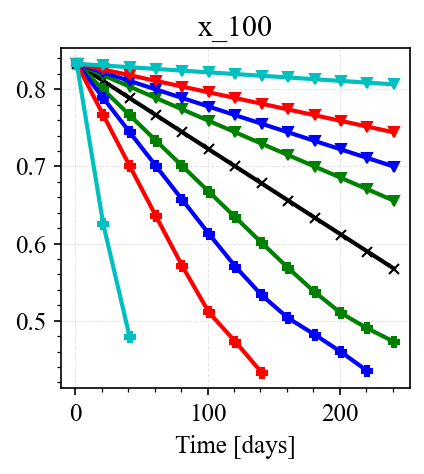

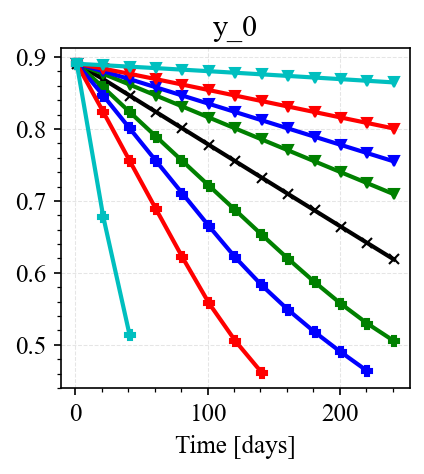

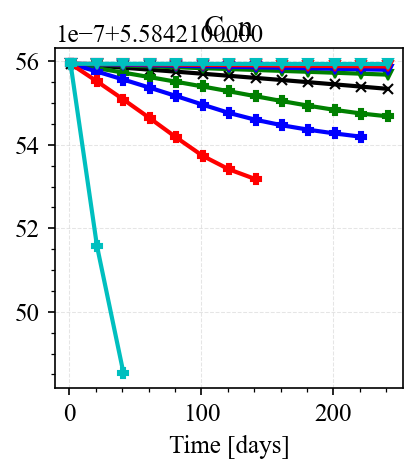

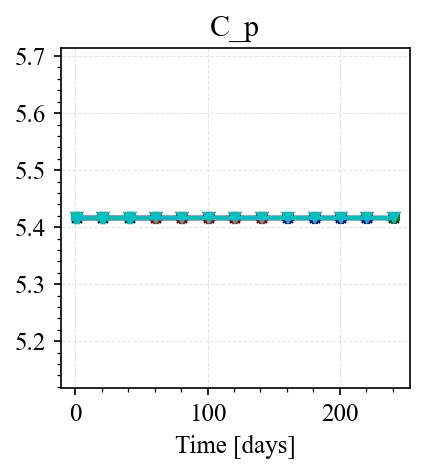

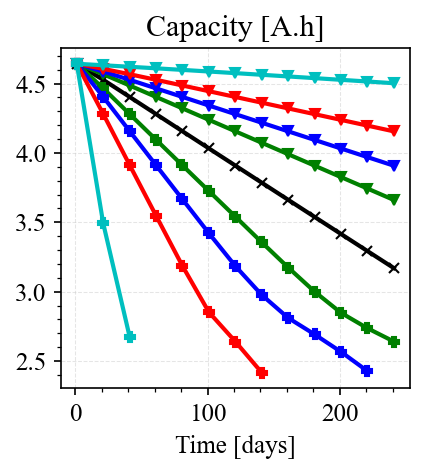

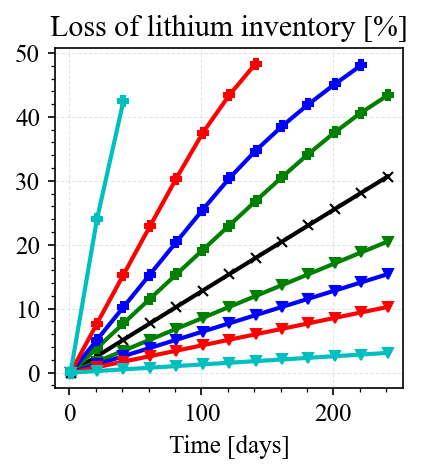

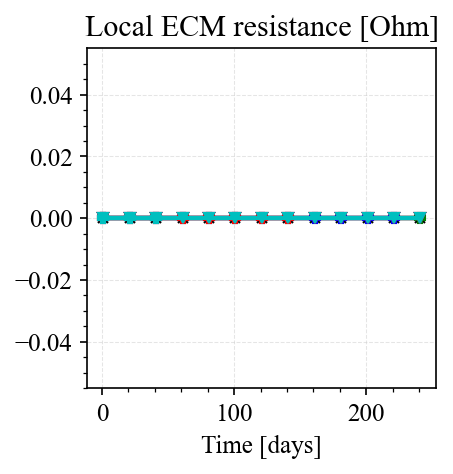

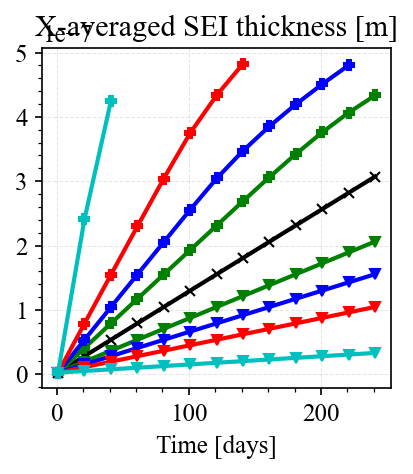

In [29]:
esoh_vars = ["x_100", "y_0", "C_n", "C_p", "Capacity [A.h]", "Loss of lithium inventory [%]","Local ECM resistance [Ohm]","X-averaged SEI thickness [m]"]
esoh_vars_str = ["x_100", "y_0", "C_n", "C_p", "cap", "LLI","res","sei"]
for ev_num in range(len(esoh_vars)):
    fig, ax = plt.subplots(1,1,figsize=(3,3))
    col = ['k','g','b','r','c']
    col_idx = [x // 2 +1 for x in range(-1,8)]
    mar_idx = [x % 2 for x in range(-1,8)]
    mar_idx[0]=2
    mar = [u'v',u'P',u'x']
    for k in range(len(dfl)):
        ax.plot(dfl[k]['Cycle number'],dfl[k][esoh_vars[ev_num]],color=col[col_idx[k]],marker=mar[mar_idx[k]])
        ax.set_title(split_long_string(esoh_vars[ev_num]))
        ax.set_xlabel('Time [days]')
    # fig.legend(Temp_s, 
    #            loc="lower center",bbox_to_anchor=[0.5,-0.3], ncol=3, fontsize=11)
    plt.savefig(fig_DIR+'sens_T_{0}_k_{1}_D_{2}'.format(Temp_idx,ksei_idx,dsei_idx)+'_comp_'+esoh_vars_str[ev_num]+'.png')

# Calculate RMSE

In [30]:
dfsdf

NameError: name 'dfsdf' is not defined

In [ ]:
esoh_vars = ["x_100", "y_0", "C_n", "C_p", "Capacity [A.h]", "Loss of lithium inventory [%]","Local ECM resistance [Ohm]","X-averaged SEI thickness [m]"]
esoh_vars_str = ["x_100", "y_0", "C_n", "C_p", "cap", "LLI","res","sei"]
for ev_num in range(len(esoh_vars)):
    print([esoh_vars[ev_num]])
    rmse_stats = []
    for k in range(len(dfl)):
        rmse_t=((dfl_m[k][esoh_vars[ev_num]] - df_base[esoh_vars[ev_num]]) ** 2).mean() ** .5
        rmse_stats.append(rmse_t)
    print(rmse_stats)

['x_100']
[0.0, 0.05195744532437685, 0.06969374744077009, 0.07804809815625985, 0.11614372637471826, 0.10419178754390726, 0.1706344285111686, 0.14084695759215415, 0.20070663309653922]
['y_0']
[0.0, 0.05356939392648838, 0.07489483535560193, 0.08046555648882814, 0.12686249213865913, 0.10740777066144395, 0.1872728046318998, 0.14500853135610065, 0.21862620471190283]
['C_n']
[0.0, 1.9589536601612486e-08, 4.227069764459498e-08, 2.6322353347663445e-08, 8.580953752113335e-08, 3.098665590451324e-08, 1.8614511501762384e-07, 3.440302419252327e-08, 6.598278338066809e-07]
['C_p']
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
['Capacity [A.h]']
[0.0, 0.29009842391954005, 0.3891567378942656, 0.43574695445405315, 0.6485270994219531, 0.5816288907082299, 0.9527936383258085, 0.785122560871067, 1.1206568292424952]
['Loss of lithium inventory [%]']
[0.0, 6.003376811302371, 8.392582998280947, 9.018087568444164, 14.215915617024594, 12.039257703232888, 20.985357167694854, 16.277213022081067, 24.499875618160488